In [1]:
%cd ..

/Users/heilman/galvanize/recipe-vectorizer


In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import pymongo
from collections import Counter
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from networkx.algorithms.community.centrality import girvan_newman
from string import *
from src.functions import *
from src.modeling_functions import *
import imageio
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
recipes_coll = pymongo.MongoClient()['allrecipes']['recipes']

In [4]:
all_recipes = list(recipes_coll.find())

In [5]:
len(all_recipes)

2570

In [6]:
df = create_dataframe(all_recipes, cutoff=10)

In [7]:
X = df.values
cosine_sims = cosine_similarity(X)

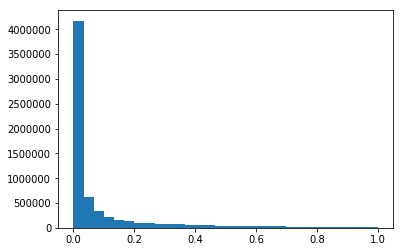

In [36]:
plt.hist(cosine_sims.flatten(), bins=30);

DBSCAN(DB, distFunc, eps, minPts) {
   C = 0                                                  /* Cluster counter */
   for each point P in database DB {
      if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
      Neighbors N = RangeQuery(DB, distFunc, P, eps)      /* Find neighbors */
      if |N| < minPts then {                              /* Density check */
         label(P) = Noise                                 /* Label as Noise */
         continue
      }
      C = C + 1                                           /* next cluster label */
      label(P) = C                                        /* Label initial point */
      Seed set S = N \ {P}                                /* Neighbors to expand */
      for each point Q in S {                             /* Process every seed point */
         if label(Q) = Noise then label(Q) = C            /* Change Noise to border point */
         if label(Q) ≠ undefined then continue            /* Previously processed */
         label(Q) = C                                     /* Label neighbor */
         Neighbors N = RangeQuery(DB, distFunc, Q, eps)   /* Find neighbors */
         if |N| ≥ minPts then {                           /* Density check */
            S = S ∪ N                                     /* Add new neighbors to seed set */
         }
      }
   }
}

In [8]:
def dbscan(similarity_matrix, eps, min_points):
    labels = np.zeros(len(similarity_matrix))
    c = 0
    for i, row in enumerate(similarity_matrix):
        if labels[i] != 0:
            continue
        neighbors = [j for j, sim in enumerate(row) if (sim > eps) and (j != i)]
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            n = [k for k, sim in enumerate(similarity_matrix[j]) if (sim > eps) and (k != j)]
            if len(n) >= min_points:
                for point in n:
                    if point not in neighbors:
                        neighbors.append(point)
    return labels

In [55]:
Counter(labels)

Counter({-1.0: 243, 3.0: 11, 1.0: 12, 2.0: 23, 4.0: 7})

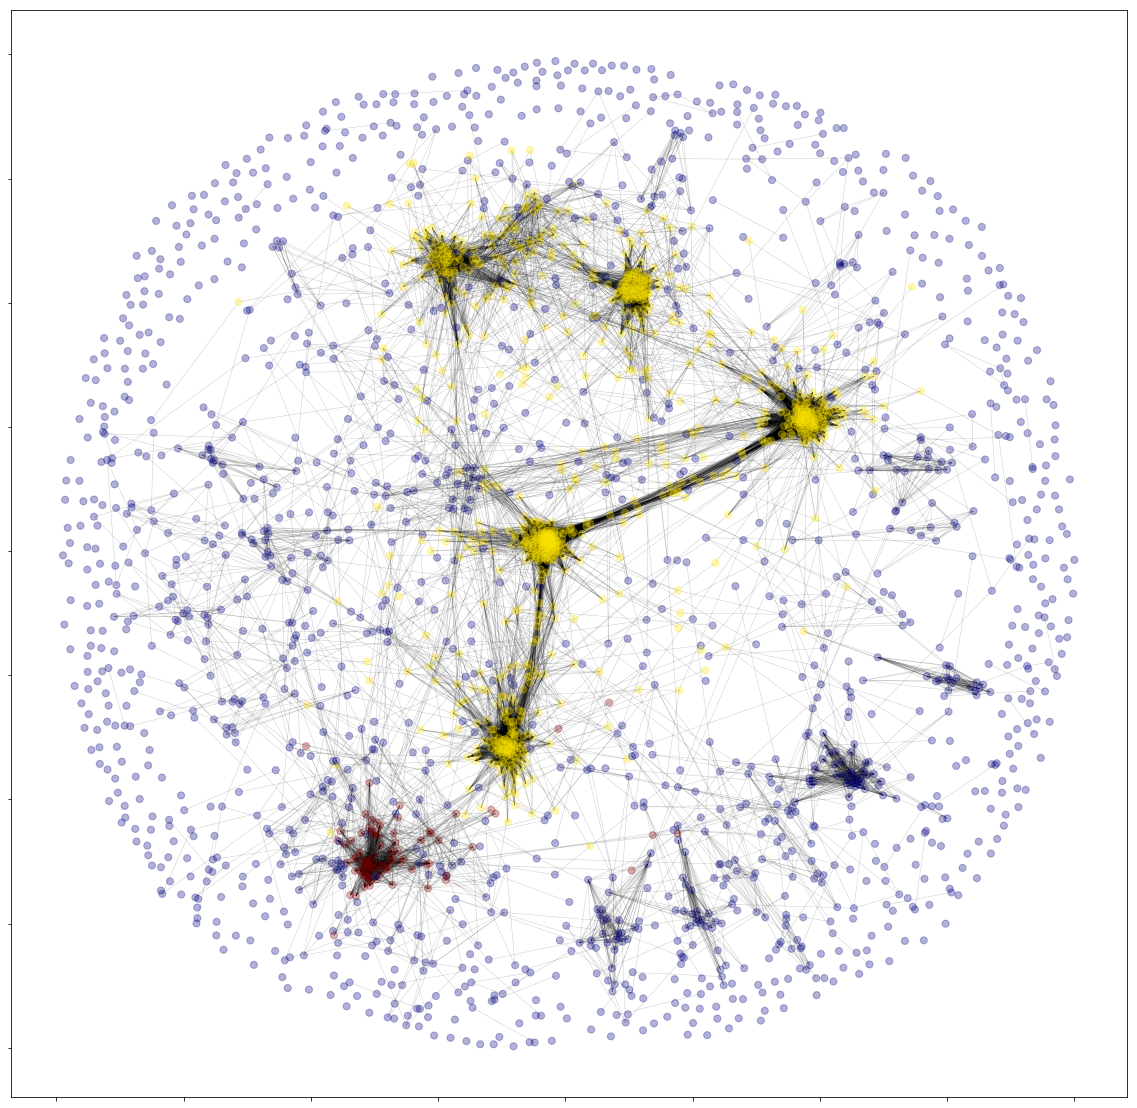

In [37]:
threshold = 0.80
min_points = 45
G = nx.Graph()
labels = dbscan(cosine_sims, threshold, min_points) 
for i in range(len(X)):
    G.add_node(i)
for i, row in enumerate(cosine_sims):
    for j in range(i+1, len(cosine_sims)):
        if cosine_sims[i,j] > threshold:
            G.add_edge(i, j, weight=100*cosine_sims[i,j])

node_colors = [cm.jet((label+1)/(max(labels)+1)) for label in labels]
spring = nx.spring_layout(G, k=0.5, weight='weight', seed=427)
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(G,
                       pos=spring,
                       node_size=50,
                       node_color=node_colors,
                       ax=ax,
                       alpha=0.3,
                       with_labels=False)
nx.draw_networkx_edges(G,
                       pos=spring,
                       edge_color='k',
                       width=0.5,
                       alpha=0.2)
ax.set_yticklabels([])
ax.set_xticklabels([]);

In [30]:
nodes = [i for i, label in enumerate(labels) if label == -1]
find_keywords(get_recipe_names(nodes, df.index, all_recipes))

[('soup', 283),
 ('chili', 240),
 ('thai', 196),
 ('chowder', 179),
 ('chicken', 169),
 ('cheese', 143),
 ('sauce', 138),
 ('curry', 115),
 ('stew', 79),
 ('potato', 77)]

In [54]:
def plot_dbscan(ax, cosine_sims, threshold, min_points):
    G = nx.Graph()
    labels = dbscan(cosine_sims, threshold, min_points) 
    for i in range(len(cosine_sims)):
        G.add_node(i)
    for i, row in enumerate(cosine_sims):
        for j in range(i+1, len(cosine_sims)):
            if cosine_sims[i,j] > threshold:
                G.add_edge(i, j, weight=100*cosine_sims[i,j])

    node_colors = [cm.jet((label+1)/(max(labels)+1)) for label in labels]
    spring = nx.spring_layout(G, k=0.5, weight='weight', seed=427)
    nx.draw_networkx_nodes(G,
                           pos=spring,
                           node_size=50,
                           node_color=node_colors,
                           ax=ax,
                           alpha=0.3,
                           with_labels=False)
    nx.draw_networkx_edges(G,
                           pos=spring,
                           edge_color='k',
                           width=0.5,
                           alpha=0.2)
    
    ax.text(-1.05, 1,'Threshold : {0:4.2}'.format(threshold), fontsize=15)
    ax.text(-1.05, .9,'Min. points : {}'.format(int(min_points)), fontsize=15)
    ax.text(-1.05, .8,'Clusters : {}'.format(int(max(labels))), fontsize=15)
    ax.set_xlim(left=-1.1, right = 1.1)
    ax.set_ylim(bottom=-1.1, top = 1.1)
    ax.set_yticklabels([])
    ax.set_xticklabels([]);

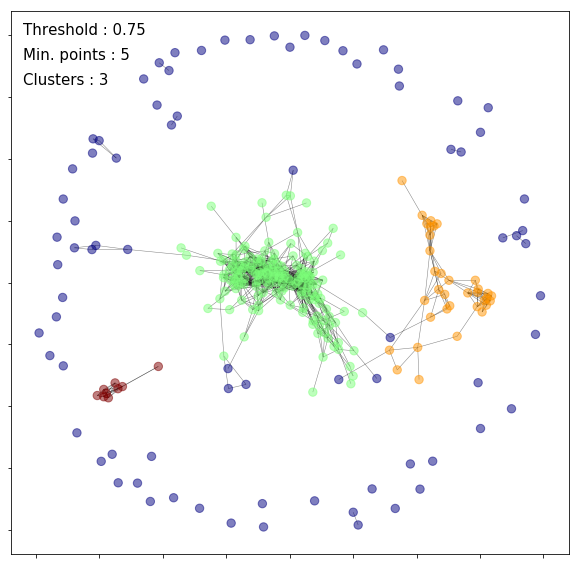

In [161]:
fig, ax = plt.subplots(figsize=(10,10))
plot_dbscan(ax, cosine_sims, 0.75, 5)

### Threshold Sweep

In [33]:
n=15
min_points = 10
figsize=(20,20)
repeats = 3
duration = 1

frames = []
print('0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%')
print('|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|')
for i, thresh in enumerate(np.linspace(.7,.98, n)):
    pct = int((i/n) * 100)
    print('|{0}{1}| {2}% complete'.format('='*pct, '.'*(99-pct),pct), end='\r')
    fig, ax = plt.subplots(figsize=figsize)
    plot_dbscan(ax, cosine_sims, thresh, min_points)
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    frames.append(img)
    if i==0 or i==n-1:
        for _ in range(repeats):
            frames.append(img)
    pct = int(((i+1)/n) * 100)
    s = '='*pct if pct != 100 else '='*99
    print('|{0}{1}| {2}% complete'.format(s, '.'*(99-pct),pct), end='\r')
    
imageio.mimsave('images/dbscan-all-threshold-sweep-mp{}.gif'.format(min_points), frames, duration=duration)


0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%
|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|


### min_points sweep

In [32]:
n=13
threshold = 0.75
figsize=(20,20)
repeats = 3
duration = 2

frames = []
print('0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%')
print('|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|')
for i, min_points in enumerate(np.linspace(30,150, n)):
    pct = int((i/n) * 100)
    print('|{0}{1}| {2}% complete'.format('='*pct, '.'*(99-pct),pct), end='\r')
    fig, ax = plt.subplots(figsize=figsize)
    plot_dbscan(ax, cosine_sims, threshold, min_points)
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    frames.append(img)
    if i==0 or i==n-1:
        for _ in range(repeats):
            frames.append(img)
    pct = int(((i+1)/n) * 100)
    s = '='*pct if pct != 100 else '='*99
    print('|{0}{1}| {2}% complete'.format(s, '.'*(99-pct),pct), end='\r')
    
imageio.mimsave('images/dbscan-all-minpoints-sweep_t75.gif', frames, duration=duration)

0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%
|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|


### Adaptive DBSCAN

#### Start with low min_points, low threshold

In [71]:
threshold = 0.8
min_points = 10
labels = dbscan(cosine_sims, threshold, min_points)

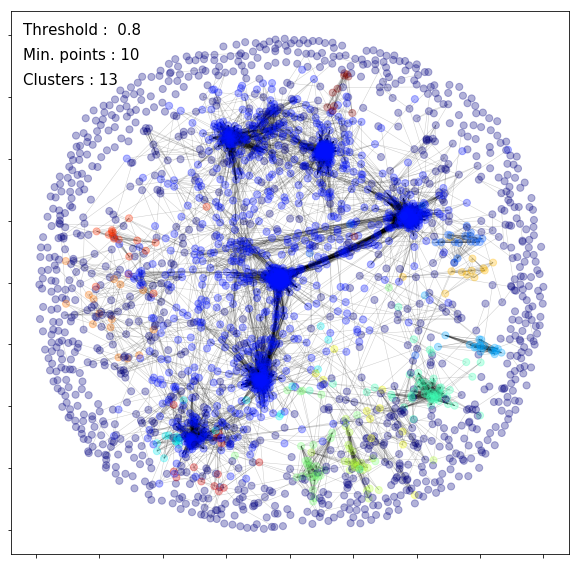

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
plot_dbscan(ax, cosine_sims, threshold, min_points)

In [72]:
n_clusters = max(labels)
cluster_sizes = Counter(labels)
cluster_sizes

Counter({1.0: 1203,
         -1.0: 1112,
         9.0: 12,
         4.0: 20,
         8.0: 11,
         2.0: 22,
         3.0: 20,
         7.0: 26,
         5.0: 56,
         6.0: 32,
         10.0: 15,
         11.0: 17,
         13.0: 11,
         12.0: 13})

#### Select largest cluster, increase min_points, and repeat

In [75]:
C1_idx = [i for i, label in enumerate(labels) if label==1]
C1_X = df.iloc[C1_idx, :].values
C1_cos_sims = cosine_similarity(C1_X)
min_points = 20
C1_labels = dbscan(C1_cos_sims, threshold, min_points)
Counter(C1_labels)

Counter({1.0: 1017, -1.0: 67, 2.0: 119})

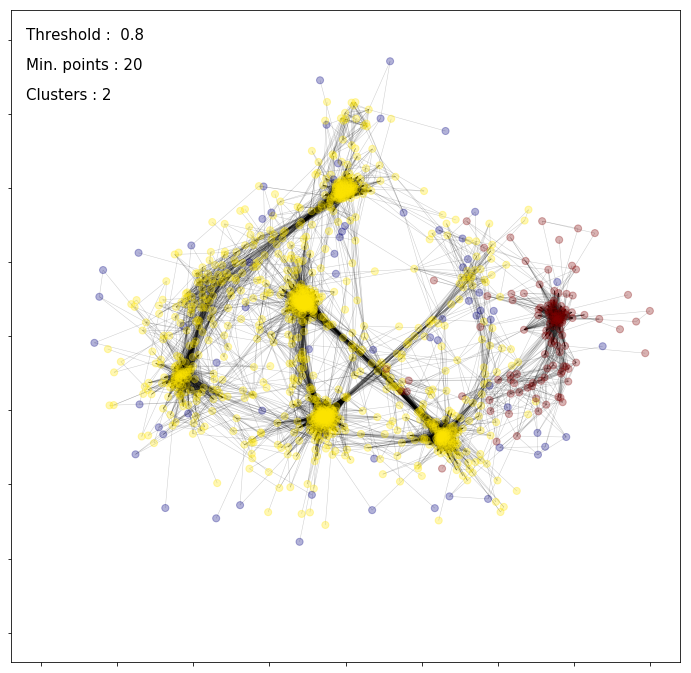

In [76]:
fig, ax = plt.subplots(figsize=(12,12))
plot_dbscan(ax, C1_cos_sims, threshold, min_points)

In [83]:
C2_idx = np.array(C1_idx)[[i for i, label in enumerate(C1_labels) if label==1]]
C2_X = df.iloc[C2_idx, :].values
C2_cos_sims = cosine_similarity(C2_X)
min_points = 60
C2_labels = dbscan(C2_cos_sims, threshold, min_points)
Counter(C2_labels)

Counter({-1.0: 153, 1.0: 719, 2.0: 145})

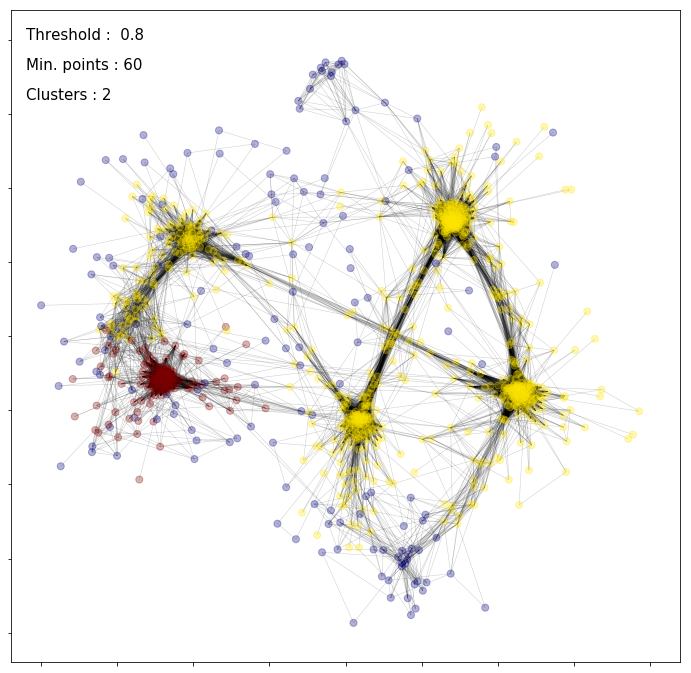

In [84]:
fig, ax = plt.subplots(figsize=(12,12))
plot_dbscan(ax, C2_cos_sims, threshold, min_points)

In [86]:
C3_idx = np.array(C2_idx)[[i for i, label in enumerate(C2_labels) if label==1]]
C3_X = df.iloc[C3_idx, :].values
C3_cos_sims = cosine_similarity(C3_X)
min_points = 70
C3_labels = dbscan(C3_cos_sims, threshold, min_points)
Counter(C3_labels)

Counter({1.0: 96, -1.0: 45, 2.0: 578})

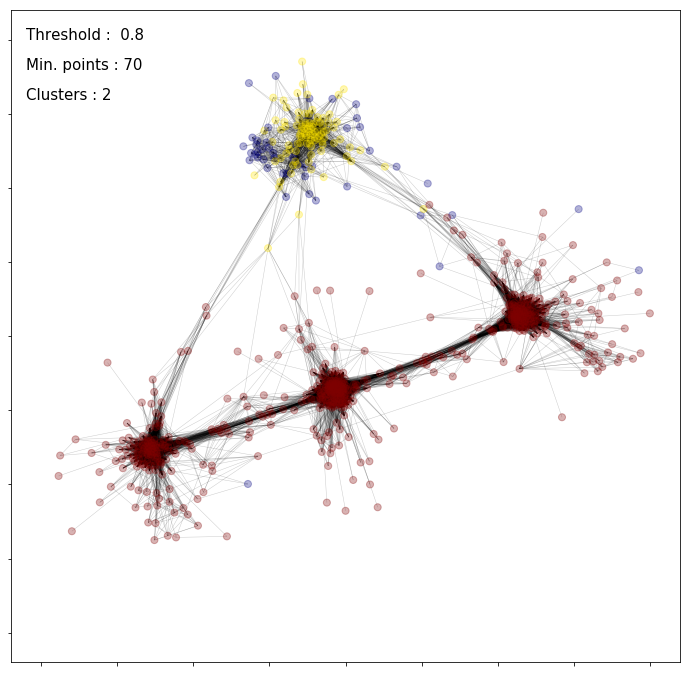

In [87]:
fig, ax = plt.subplots(figsize=(12,12))
plot_dbscan(ax, C3_cos_sims, threshold, min_points)

In [90]:
C4_idx = np.array(C3_idx)[[i for i, label in enumerate(C3_labels) if label==2]]
C4_X = df.iloc[C4_idx, :].values
C4_cos_sims = cosine_similarity(C4_X)
min_points = 80
C4_labels = dbscan(C4_cos_sims, threshold, min_points)
Counter(C4_labels)

Counter({1.0: 425, 2.0: 145, -1.0: 8})

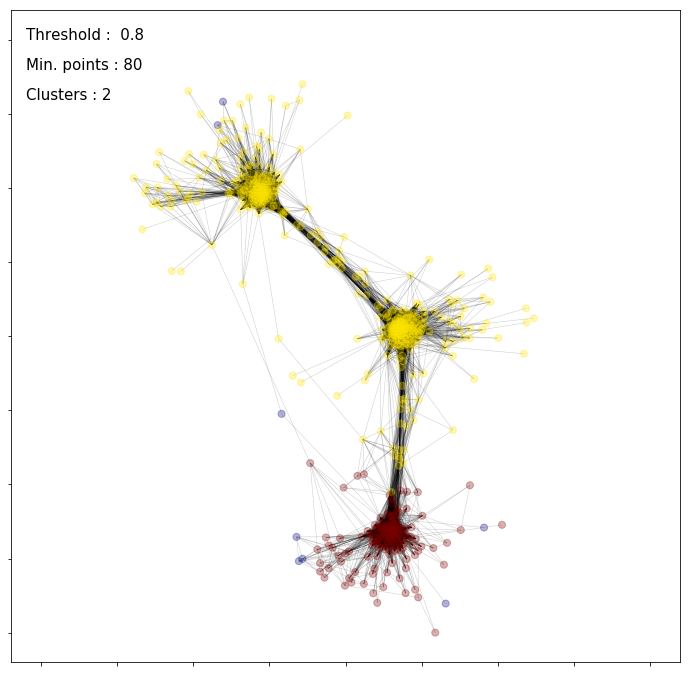

In [91]:
fig, ax = plt.subplots(figsize=(12,12))
plot_dbscan(ax, C4_cos_sims, threshold, min_points)

In [95]:
C5_idx = np.array(C4_idx)[[i for i, label in enumerate(C4_labels) if label==1]]
C5_X = df.iloc[C5_idx, :].values
C5_cos_sims = cosine_similarity(C5_X)
min_points = 110
C5_labels = dbscan(C5_cos_sims, threshold, min_points)
Counter(C5_labels)

Counter({2.0: 170, 1.0: 221, -1.0: 34})

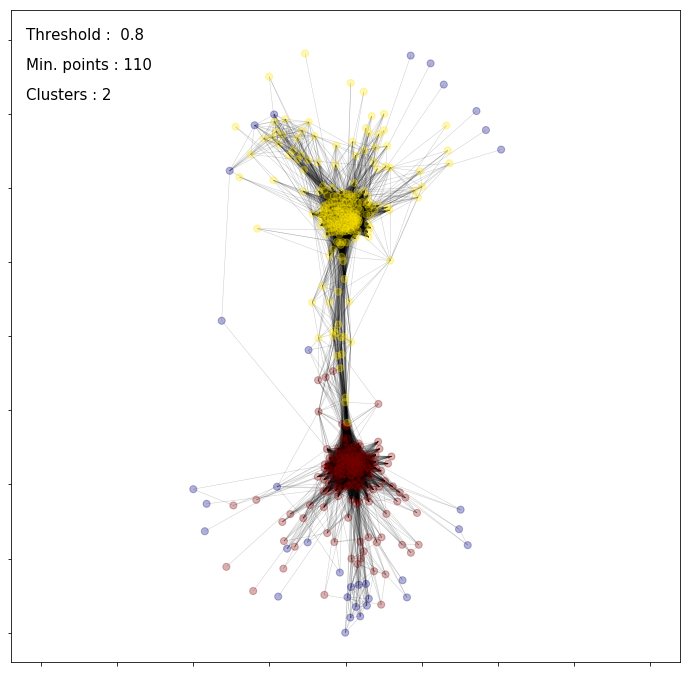

In [96]:
fig, ax = plt.subplots(figsize=(12,12))
plot_dbscan(ax, C5_cos_sims, threshold, min_points)

In [97]:
C1_idx

[0,
 2,
 4,
 6,
 7,
 9,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 22,
 23,
 24,
 25,
 27,
 29,
 30,
 31,
 33,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 53,
 54,
 55,
 57,
 58,
 60,
 61,
 64,
 66,
 68,
 69,
 70,
 71,
 72,
 73,
 75,
 76,
 78,
 80,
 82,
 83,
 84,
 88,
 89,
 90,
 91,
 92,
 99,
 100,
 103,
 104,
 106,
 110,
 111,
 112,
 114,
 116,
 117,
 118,
 120,
 124,
 126,
 127,
 128,
 131,
 133,
 138,
 140,
 141,
 146,
 147,
 148,
 149,
 151,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 162,
 163,
 164,
 167,
 168,
 169,
 171,
 173,
 176,
 179,
 180,
 184,
 186,
 187,
 188,
 194,
 195,
 196,
 198,
 200,
 201,
 203,
 205,
 208,
 209,
 210,
 212,
 213,
 214,
 218,
 220,
 221,
 223,
 226,
 227,
 228,
 231,
 232,
 235,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 246,
 248,
 253,
 254,
 255,
 256,
 257,
 258,
 260,
 261,
 263,
 265,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 277,
 278,
 279,
 280,
 281,
 283,
 284,
 286,
 287,
 288,
 291,
 293,
 294,
 295,
 296,


### Create animation of modified DBSCAN

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


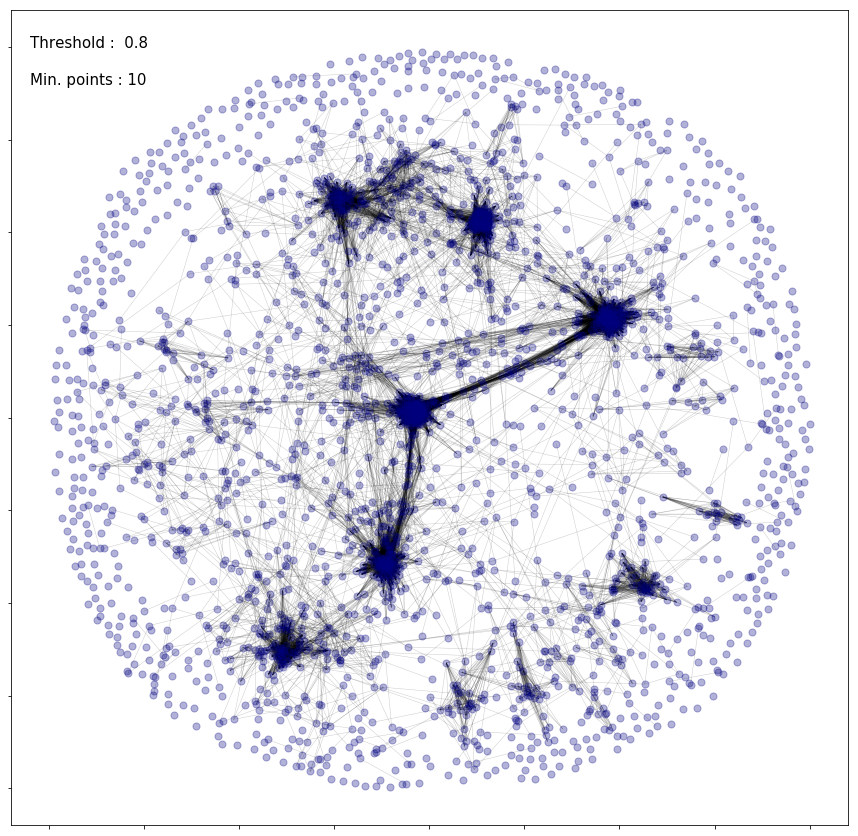

In [99]:
threshold=0.8
min_points = 10
labels = dbscan(cosine_sims, threshold, min_points) 

G = nx.Graph()
for i in range(len(cosine_sims)):
    G.add_node(i)
for i, row in enumerate(cosine_sims):
    for j in range(i+1, len(cosine_sims)):
        if cosine_sims[i,j] > threshold:
            G.add_edge(i, j, weight=100*cosine_sims[i,j])

fig, ax = plt.subplots(figsize=(15,15))
#node_colors = [cm.jet((label+1)/(max(labels)+1)) for label in labels]
spring = nx.spring_layout(G, k=0.5, weight='weight', seed=427)
nx.draw_networkx_nodes(G,
                       pos=spring,
                       node_size=50,
                       node_color=cm.jet(0),
                       ax=ax,
                       alpha=0.3,
                       with_labels=False)
nx.draw_networkx_edges(G,
                       pos=spring,
                       edge_color='k',
                       width=0.5,
                       alpha=0.2)

ax.text(-1.05, 1,'Threshold : {0:4.2}'.format(threshold), fontsize=15)
ax.text(-1.05, .9,'Min. points : {}'.format(int(min_points)), fontsize=15)
#ax.text(-1.05, .8,'Clusters : {}'.format(int(max(labels))), fontsize=15)
ax.set_xlim(left=-1.1, right = 1.1)
ax.set_ylim(bottom=-1.1, top = 1.1)
ax.set_yticklabels([])
ax.set_xticklabels([]);

In [100]:
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
frame_0 = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

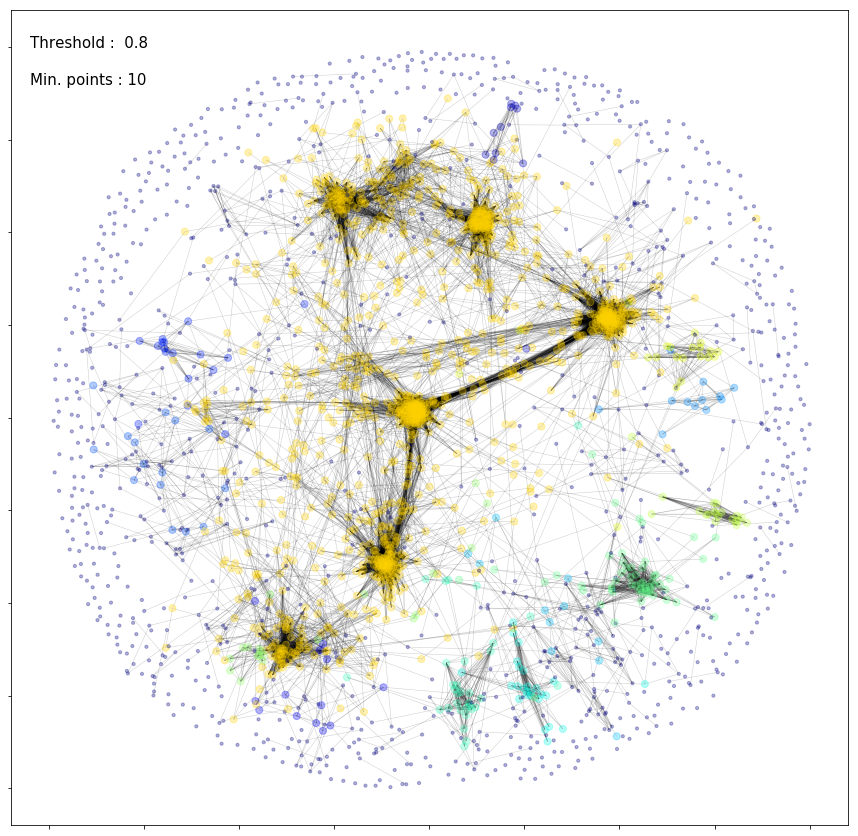

In [103]:
threshold=0.8
min_points = 10
labels = dbscan(cosine_sims, threshold, min_points) 

G = nx.Graph()
for i in range(len(cosine_sims)):
    G.add_node(i)
for i, row in enumerate(cosine_sims):
    for j in range(i+1, len(cosine_sims)):
        if cosine_sims[i,j] > threshold:
            G.add_edge(i, j, weight=100*cosine_sims[i,j])

fig, ax = plt.subplots(figsize=(15,15))

node_sizes = [10 if label==-1 else 50 for label in labels]
node_colors = [cm.jet((14-label)/19) if label != -1 else cm.jet(0) for label in labels]
spring = nx.spring_layout(G, k=0.5, weight='weight', seed=427)
nx.draw_networkx_nodes(G,
                       pos=spring,
                       node_size=node_sizes,
                       node_color=node_colors,
                       ax=ax,
                       alpha=0.3,
                       with_labels=False)
nx.draw_networkx_edges(G,
                       pos=spring,
                       edge_color='k',
                       width=0.5,
                       alpha=0.2)

ax.text(-1.05, 1,'Threshold : {0:4.2}'.format(threshold), fontsize=15)
ax.text(-1.05, .9,'Min. points : {}'.format(int(min_points)), fontsize=15)
#ax.text(-1.05, .8,'Clusters : {}'.format(int(max(labels))), fontsize=15)
ax.set_xlim(left=-1.1, right = 1.1)
ax.set_ylim(bottom=-1.1, top = 1.1)
ax.set_yticklabels([])
ax.set_xticklabels([]);

In [104]:
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
frame_1 = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

array([ 1.,  1.,  1., ...,  1.,  1., -1.])

In [115]:
stages = []
cluster_numbers = np.zeros(len(X))
stages.append(cluster_numbers.copy())

for i, label in enumerate(labels):
    if label == -1:
        cluster_numbers[i] = -1
    else:
        cluster_numbers[i] = max(labels) - label + 1

stages.append(cluster_numbers.copy())

for idx, label in zip(C1_idx, C1_labels):
    if label == -1:
        cluster_numbers[idx] = -1
    else:
        cluster_numbers[idx] += 2 - label
stages.append(cluster_numbers.copy())

for idx, label in zip(C2_idx, C2_labels):
    if label == -1:
        cluster_numbers[idx] = -1
    else:
        cluster_numbers[idx] += 2 - label
stages.append(cluster_numbers.copy())

for idx, label in zip(C3_idx, C3_labels):
    if label == -1:
        cluster_numbers[idx] = -1
    else:
        cluster_numbers[idx] += label - 1
stages.append(cluster_numbers.copy())

for idx, label in zip(C4_idx, C4_labels):
    if label == -1:
        cluster_numbers[idx] = -1
    else:
        cluster_numbers[idx] += 2 - label
stages.append(cluster_numbers.copy())

for idx, label in zip(C5_idx, C5_labels):
    if label == -1:
        cluster_numbers[idx] = -1
    else:
        cluster_numbers[idx] += 2 - label
stages.append(cluster_numbers.copy())
#node_sizes = [10 if label==-1 else 50 for label in labels]
#node_colors = [cm.jet((14-label)/19) if label != -1 else cm.jet(0) for label in labels]

In [ ]:
frames = []
for i in range(7):
    print('Rendering plot {} of 7'.format(i+1))
    fig, ax = plt.subplots(figsize=(15,15))
    node_sizes = [10 if label==-1 else 50 for label in stages[i]]
    node_colors = [cm.prism(label/18) for label in stages[i]]
    spring = nx.spring_layout(G, k=0.5, weight='weight', seed=427)
    nx.draw_networkx_nodes(G,
                           pos=spring,
                           node_size=node_sizes,
                           node_color=node_colors,
                           ax=ax,
                           alpha=0.3,
                           with_labels=False)
    nx.draw_networkx_edges(G,
                           pos=spring,
                           edge_color='k',
                           width=0.5,
                           alpha=0.2)

    #ax.text(-1.05, 1,'Threshold : {0:4.2}'.format(threshold), fontsize=15)
    #ax.text(-1.05, .9,'Min. points : {}'.format(int(min_points)), fontsize=15)
    #ax.text(-1.05, .8,'Clusters : {}'.format(int(max(stages[i]))), fontsize=15)
    ax.set_xlim(left=-1.1, right = 1.1)
    ax.set_ylim(bottom=-1.1, top = 1.1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    frames.append(img)

Rendering plot 1 of 7
Rendering plot 2 of 7
Rendering plot 3 of 7


In [ ]:
imageio.mimsave('images/modified-dbscan-prism.gif', frames, duration=1)